In [12]:
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
class function:
    def __init__(self, dim, value, grad, hessian):
        self.dim = dim
        self.value = value
        self.grad = grad
        self.hessian = hessian

In [4]:
class probleme:
    def __init__(self, f):
        self.f = f
        
    def __call__(self, x):
        return self.f.value(x)

In [5]:
f_d = {
    "dim": 1,
    "value": lambda x: x[0]**2 - 5 * x[0] + 3,
    "grad": lambda x: np.array([2*x[0] - 5]),
    "hessian": lambda x: np.diag([2])
}
f = function(**f_d)
P = probleme(f)

# Méthode de Newton

In [6]:
def newton_method(f, x0, epsilon=0.1):
    save = []
    x = x0
    save.append(x)
    dxN = -1 * np.dot(np.linalg.inv(f.hessian(x)), f.grad(x))
    lmd = -1 * np.dot(f.grad(x).T, dxN)
    while lmd / 2 > epsilon:
        dxN = -1 * np.dot(np.linalg.inv(f.hessian(x)), f.grad(x))
        lmd = -1 * np.dot(f.grad(x).T, dxN)
        t = 0.5
        x = x + t * dxN
        save.append(x)
    return x, np.array(save)

In [7]:
x, save = newton_method(f, [5], 0.1)

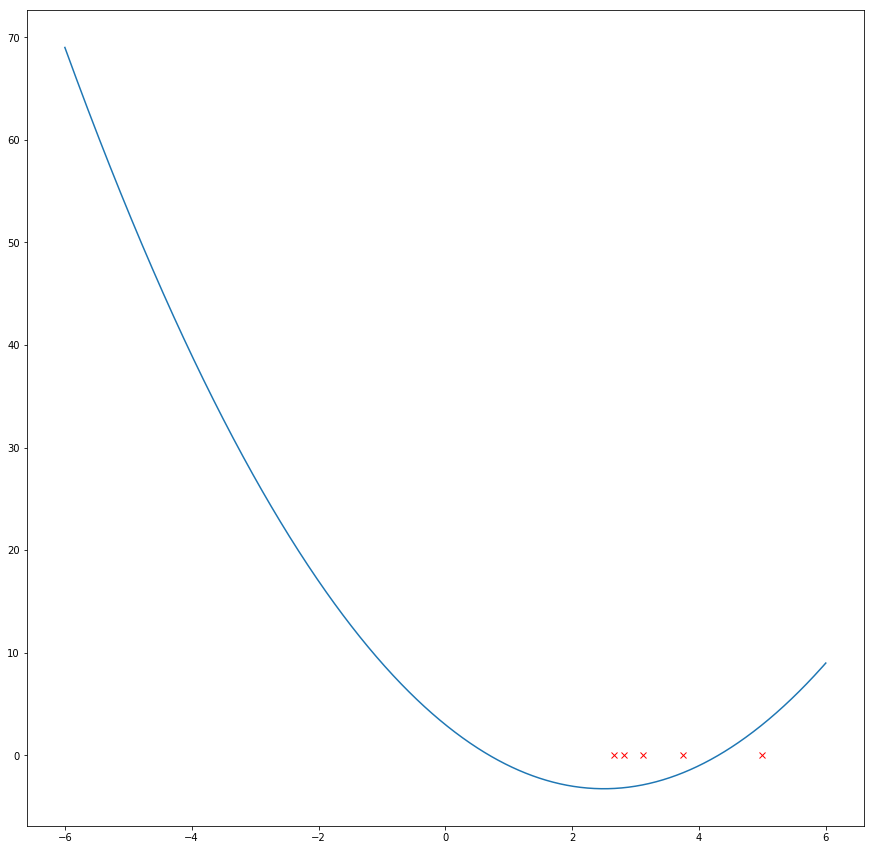

In [8]:
plt.figure(figsize=(15, 15))
x = np.linspace(-6, 6, 1000).reshape((1, -1))
plt.plot(x.reshape((-1)), f.value(x))
save.shape
plt.plot(save[:, 0], np.zeros((save.shape[0])), "rx")

# Dimension 2

In [9]:
f_2_d = {
    "dim": 2,
    "value": lambda x: x[0]**2 + x[1]**2,
    "grad": lambda x: np.array([2 * x[0], 2 * x[1]]),
    "hessian": lambda x: np.diag([2, 2])
}
f_2 = function(**f_2_d)

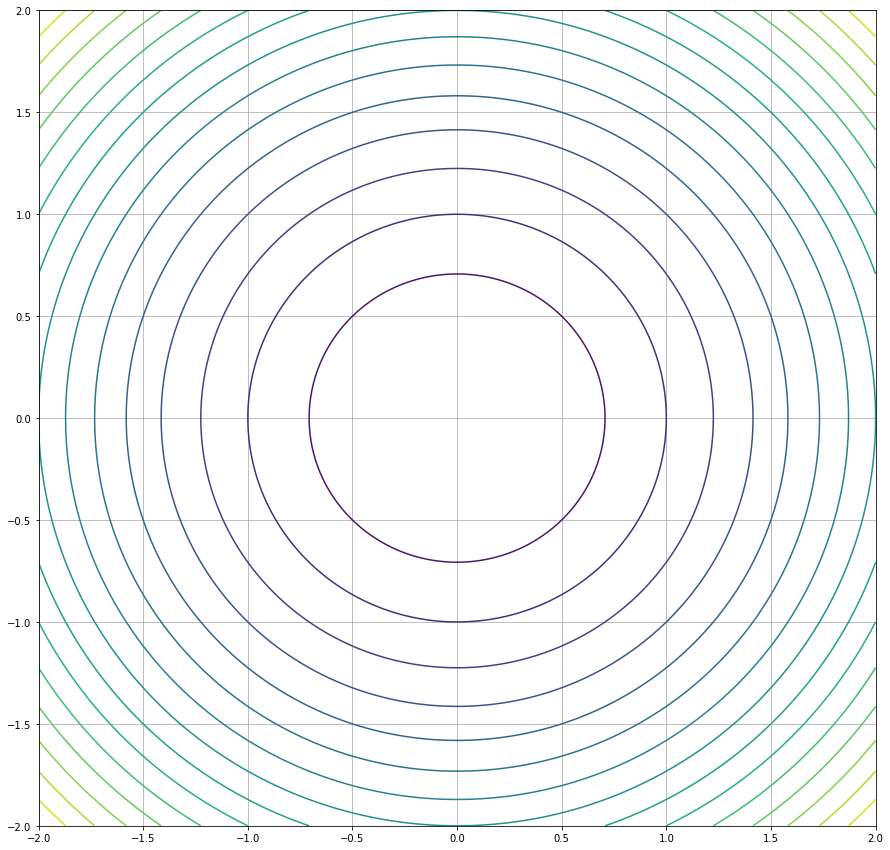

In [10]:
plt.figure(figsize=(15, 15))
x, y = np.linspace(-2, 2, 200), np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(2, -1)
plt.contour(X, Y, f_2.value(x_y).reshape(200, -1), 15)
plt.grid()
plt.show()

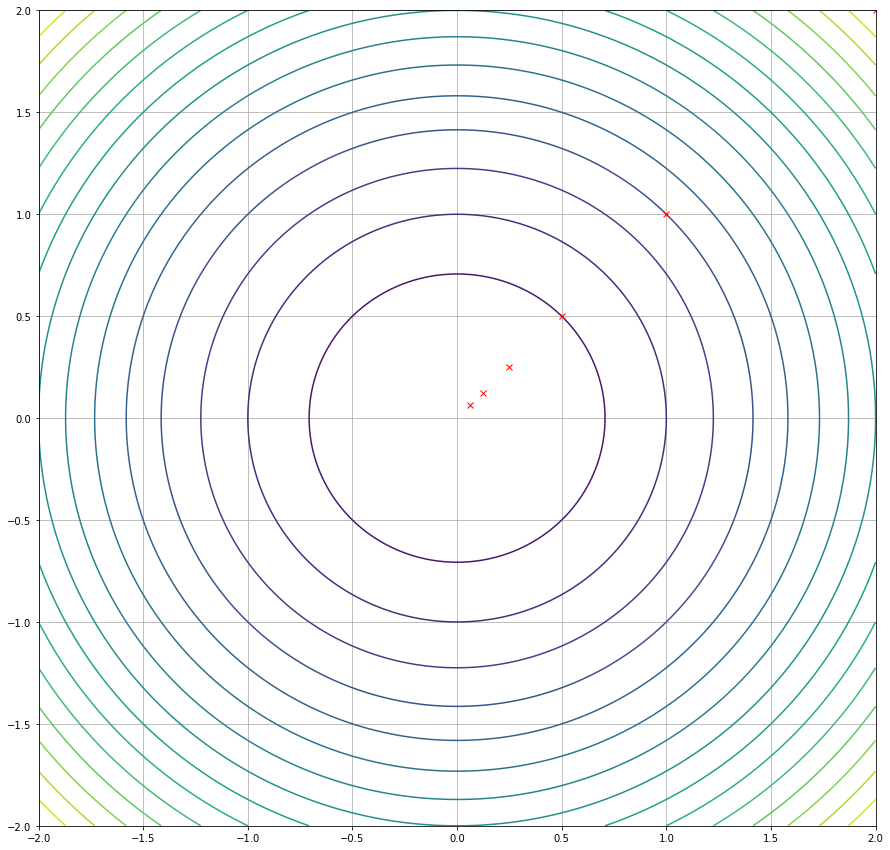

In [11]:
x, save = newton_method(f_2, np.array([2, 2]))

plt.figure(figsize=(15, 15))
x, y = np.linspace(-2, 2, 200), np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(2, -1)
plt.contour(X, Y, f_2.value(x_y).reshape(200, -1), 15)
plt.plot(save[:, 0], save[:, 1], "rx")
plt.grid()
plt.show()

# Descente de Gradient

In [14]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - dir_x (ndarray) : descent direction
              - grad (function) : gradient function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x =  rate_ * dir_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

In [15]:
GD_default = GD()

In [21]:
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : f.value (x, 2)), 
                                             (lambda x, f, tol : f.grad (x, 2)), True)

AttributeError: 'function' object has no attribute 'grad'